# Regression Deep Learning Model for White Wine Quality Using Keras
### David Lowe
### December 2, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Wine Quality dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: The dataset is related to the white variants of the Portuguese "Vinho Verde" wine. The problem is to predict the wine quality using solely the chemical characteristics of the wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

ANALYSIS: The baseline performance of the model achieved an RMSE of 0.726. After tuning the hyperparameters, the best model processed the training dataset with an RMSE of 0.714. Furthermore, the final model processed the test dataset with an RMSE of 0.693, which was slightly worse than the baseline result from the training dataset.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: Wine Quality Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/wine+quality

Any deep-learning modeling project genrally can be broken down into about seven major tasks:
0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Using TensorFlow backend.


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
verbose = True
tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_kernel_init = K.initializers.RandomNormal(seed=seedNum)
default_loss = 'mean_squared_error'
default_optimizer = 'adam'
default_epochs = 500
default_batches = 32

Num GPUs Available:  0


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [8]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
Xy_original = pd.read_csv(dataset_path, sep=";")

# Take a peek at the dataframe after the import
Xy_original.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [10]:
Xy_original.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [11]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [12]:
# Not applicable for this iteration of the project

## 1.c) Feature Scaling and Pre-processing

In [13]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [14]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (4898, 12) X_original.shape: (4898, 11) y_original.shape: (4898,)


In [15]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

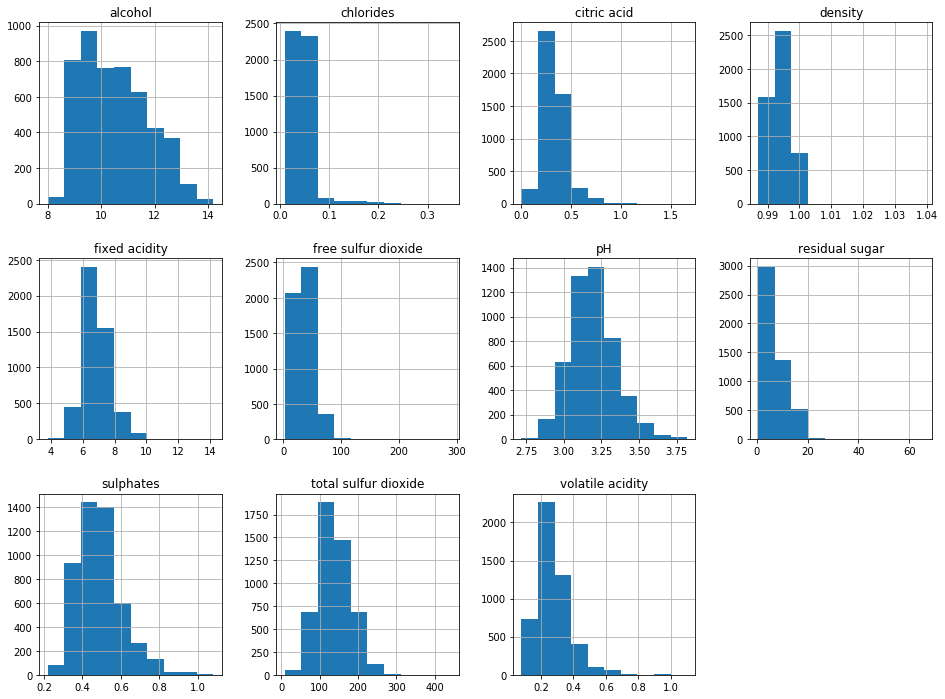

In [16]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [17]:
# Apply feature scaling and transformation
# X_original = X_original.astype(float)
# X_original['some_feature'] = preprocessing.scale(X_original['some_feature'])
preprocessing.scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.normalize(X_original['some_feature'])
# preprocessing.normalize(X_original, copy=False)
print(X_original.head(-10))

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.172097         -0.081770     0.213280        2.821349  -0.035355   
1         -0.657501          0.215896     0.048001       -0.944765   0.147747   
2          1.475751          0.017452     0.543838        0.100282   0.193523   
3          0.409125         -0.478657    -0.117278        0.415768   0.559727   
4          0.409125         -0.478657    -0.117278        0.415768   0.559727   
...             ...               ...          ...             ...        ...   
4883      -2.316697          1.902667    -1.356871       -0.885612  -0.493110   
4884      -0.420473          0.513561     0.378559        0.376332   0.101972   
4885      -0.301959          0.612783     0.543838        0.336897   0.010421   
4886      -0.776015         -0.677101    -0.447836       -0.136332  -0.813539   
4887      -0.776015          1.307336    -0.943673       -0.885612  -1.042416   

      free sulfur dioxide  

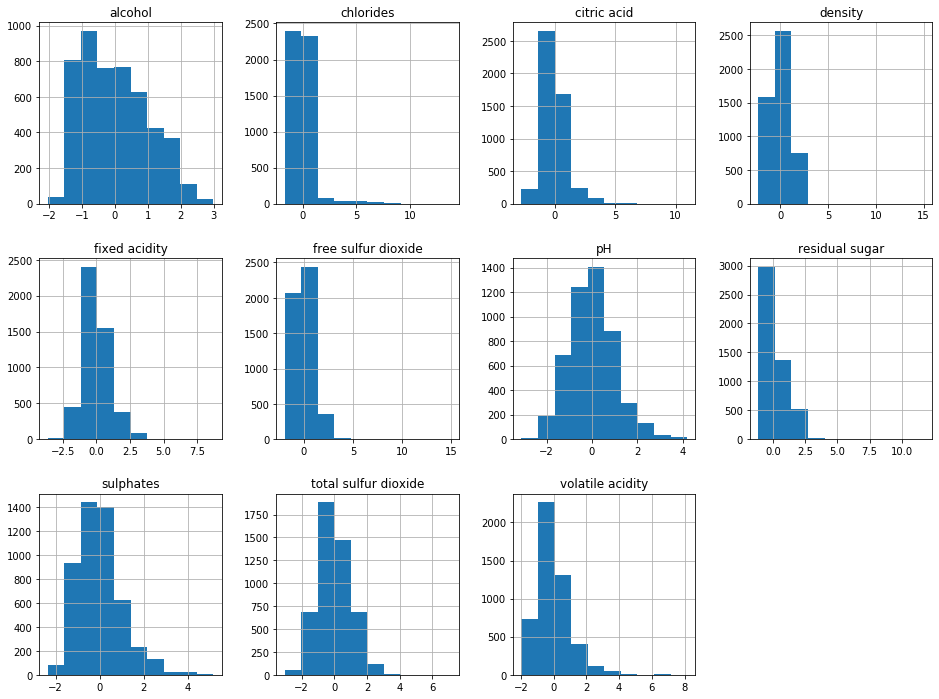

In [18]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [19]:
X_encoded = X_original.values
y_encoded = y_original.values
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (3673, 11) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (3673,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (1225, 11) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (1225,) y_test.type: <class 'numpy.ndarray'>


In [20]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [21]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [22]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(25, input_shape=(11,), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [23]:
# Initialize the Keras model
cv_model = KerasRegressor(build_fn=create_default_model, epochs=default_epochs, batch_size=default_batches, verbose=0)

In [24]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [25]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [26]:
startTimeModule = datetime.now()

# Fit and evaluate the Keras model using k-fold cross validation
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_loss)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %f (%f)' % (results.mean(), results.std()))
print('Average RMSE from all cv folds is:', math.sqrt(results.mean()*-1))
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:loc

In [27]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [28]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [29]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(25, input_shape=(11,), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(1, kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer)
    return customized_model

In [30]:
startTimeModule = datetime.now()

# Create model for grid search
grid_model = KerasRegressor(build_fn=create_customized_model, verbose=0)

# Perform grid search using different epochs, batch sizes, and optimizers
optz_1 = K.optimizers.Adam(learning_rate=0.001)
optz_2 = K.optimizers.RMSprop(learning_rate=0.001)
optimizer_grid = [optz_1, optz_2]
init_1 = K.initializers.RandomNormal(seed=seedNum)
init_2 = K.initializers.Orthogonal(seed=seedNum)
init_grid = [init_1, init_2]
epoch_grid = [500, 1000]
batch_grid = [32, 64, 128]
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=n_folds, n_jobs=n_jobs, verbose=3)
# n_iter = int(len(optimizer_grid) * len(init_grid) * len(epoch_grid) * len(batch_grid) * 0.5)
# grid = RandomizedSearchCV(estimator=grid_model, param_distributions=param_grid, n_iter=n_iter, cv=n_folds, n_jobs=n_jobs, verbose=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best MSE: %f and best RMSE: %f using the parameters: %s" % (grid_result.best_score_, math.sqrt(grid_result.best_score_*-1), grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 33.7min finished


Executing op __inference_keras_scratch_graph_925337 in device /job:localhost/replica:0/task:0/device:CPU:0
Best MSE: -0.510691 and best RMSE: 0.714626 using the parameters: {'batch_size': 128, 'epochs': 500, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f7f306d3850>, 'optimizer': <keras.optimizers.Adam object at 0x7f7f306d3d90>}
-0.538172 (0.022900) with: {'batch_size': 32, 'epochs': 500, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f7f306d3a90>, 'optimizer': <keras.optimizers.Adam object at 0x7f7f306d3d90>}
-0.535889 (0.039162) with: {'batch_size': 32, 'epochs': 500, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f7f306d3a90>, 'optimizer': <keras.optimizers.RMSprop object at 0x7f7f306d3e90>}
-0.519640 (0.039542) with: {'batch_size': 32, 'epochs': 500, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f7f306d3850>, 'optimizer': <keras.optimizers.Adam object at 0x7f7f306d3d90>}
-0.530474 (0.033692) with: {'batch_size': 32, 'epochs': 50

In [31]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [32]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=0)

Forming the final model using: optimizer=<keras.optimizers.Adam object at 0x7f7f306d3d90>, kernel=<keras.initializers.Orthogonal object at 0x7f7f306d3850>, epochs=500, batch_size=128
Executing op __inference_keras_scratch_graph_983980 in device /job:localhost/replica:0/task:0/device:CPU:0


In [33]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 25)                300       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 26        
Total params: 326
Trainable params: 326
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_7', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_13', 'trainable': True, 'batch_input_shape': (None, 11), 'dtype': 'float32', 'units': 25, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_14', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}]}


In [35]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("Final MSE of the model: %f" % (scores))
print("Final RMSE of the model: %f" % (math.sqrt(scores)))

Executing op __inference_keras_scratch_graph_1042013 in device /job:localhost/replica:0/task:0/device:CPU:0
1225/1225 [==============================] - 0s 55us/step
Final MSE of the model: 0.480469
Final RMSE of the model: 0.693159


In [36]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [37]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [38]:
# Make class predictions with the model
predictions = final_model.predict(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %.1f (expected %.1f)' % (i, predictions[i], y_test[i]))

Executing op __inference_keras_scratch_graph_1042186 in device /job:localhost/replica:0/task:0/device:CPU:0
Data item #0 predicted to be 4.9 (expected 5.0)
Data item #1 predicted to be 6.8 (expected 6.0)
Data item #2 predicted to be 5.7 (expected 7.0)
Data item #3 predicted to be 5.4 (expected 5.0)
Data item #4 predicted to be 5.6 (expected 5.0)
Data item #5 predicted to be 5.3 (expected 5.0)
Data item #6 predicted to be 5.6 (expected 6.0)
Data item #7 predicted to be 6.6 (expected 6.0)
Data item #8 predicted to be 5.7 (expected 6.0)
Data item #9 predicted to be 4.8 (expected 5.0)
Data item #10 predicted to be 7.2 (expected 7.0)
Data item #11 predicted to be 6.5 (expected 6.0)
Data item #12 predicted to be 5.9 (expected 5.0)
Data item #13 predicted to be 5.2 (expected 5.0)
Data item #14 predicted to be 7.1 (expected 6.0)
Data item #15 predicted to be 6.6 (expected 6.0)
Data item #16 predicted to be 6.6 (expected 7.0)
Data item #17 predicted to be 6.4 (expected 6.0)
Data item #18 predic

In [39]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:42:58.795995
